# Cruise control

Richard M. Murray and Karl J. Åström  
17 Jun 2019

The cruise control system of a car is a common feedback system encountered in everyday life. The system attempts to maintain a constant velocity in the presence of disturbances primarily caused by changes in the slope of a road. The controller compensates for these unknowns by measuring the speed of the car and adjusting the throttle appropriately.

This notebook explores the dynamics and control of the cruise control system, following the material presenting in Feedback Systems by Astrom and Murray.  A nonlinear model of the vehicle dynamics is used, with both state space and frequency domain control laws.  The process model is presented in Section 1, and a controller based on state feedback is discussed in Section 2, where we also add integral action to the controller. In Section 3 we explore the behavior with PI control including the effect of actuator saturation and how it is avoided by windup protection.  Different methods of constructing control systems are shown, all using the InputOutputSystem class (and subclasses).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import control as ct

## Process Model

### Vehicle Dynamics

To develop a mathematical model we start with a force balance for the car body. Let $v$ be the speed of the car, $m$ the total mass (including passengers), $F$ the force generated by the contact of the wheels with the road, and $F_d$ the disturbance force due to gravity, friction, and aerodynamic drag.

In [2]:
def vehicle_update(t, x, u, params={}):
    """Vehicle dynamics for cruise control system.

    Parameters
    ----------
    x : array
         System state: car velocity in m/s
    u : array
         System input: [throttle, gear, road_slope], where throttle is
         a float between 0 and 1, gear is an integer between 1 and 5,
         and road_slope is in rad.

    Returns
    -------
    float
        Vehicle acceleration

    """
    from math import copysign, sin
    sign = lambda x: copysign(1, x)         # define the sign() function
    
    # Set up the system parameters
    m = params.get('m', 1600.)              # vehicle mass, kg
    g = params.get('g', 9.8)                # gravitational constant, m/s^2
    Cr = params.get('Cr', 0.01)             # coefficient of rolling friction
    Cd = params.get('Cd', 0.32)             # drag coefficient
    rho = params.get('rho', 1.3)            # density of air, kg/m^3
    A = params.get('A', 2.4)                # car area, m^2
    alpha = params.get(
        'alpha', [40, 25, 16, 12, 10])      # gear ratio / wheel radius

    # Define variables for vehicle state and inputs
    v = x[0]                           # vehicle velocity
    throttle = np.clip(u[0], 0, 1)     # vehicle throttle
    gear = u[1]                        # vehicle gear
    theta = u[2]                       # road slope

    # Force generated by the engine

    omega = alpha[int(gear)-1] * v      # engine angular speed
    F = alpha[int(gear)-1] * motor_torque(omega, params) * throttle

    # Disturbance forces
    #
    # The disturbance force Fd has three major components: Fg, the forces due
    # to gravity; Fr, the forces due to rolling friction; and Fa, the
    # aerodynamic drag.

    # Letting the slope of the road be \theta (theta), gravity gives the
    # force Fg = m g sin \theta.
    
    Fg = m * g * sin(theta)

    # A simple model of rolling friction is Fr = m g Cr sgn(v), where Cr is
    # the coefficient of rolling friction and sgn(v) is the sign of v (±1) or
    # zero if v = 0.
    
    Fr  = m * g * Cr * sign(v)

    # The aerodynamic drag is proportional to the square of the speed: Fa =
    # 1/2 \rho Cd A |v| v, where \rho is the density of air, Cd is the
    # shape-dependent aerodynamic drag coefficient, and A is the frontal area
    # of the car.

    Fa = 1/2 * rho * Cd * A * abs(v) * v
    
    # Final acceleration on the car
    Fd = Fg + Fr + Fa
    dv = (F - Fd) / m
    
    return dv

### Engine model

The force F is generated by the engine, whose torque is proportional to the rate of fuel injection, which is itself proportional to a control signal 0 <= u <= 1 that controls the throttle position. The torque also depends on engine speed omega.

In [3]:
def motor_torque(omega, params={}):
    # Set up the system parameters
    Tm = params.get('Tm', 190.)             # engine torque constant
    omega_m = params.get('omega_m', 420.)   # peak engine angular speed
    beta = params.get('beta', 0.4)          # peak engine rolloff

    return np.clip(Tm * (1 - beta * (omega/omega_m - 1)**2), 0, None)

Torque curves for a typical car engine. The graph on the left shows the torque generated by the engine as a function of the angular velocity of the engine, while the curve on the right shows torque as a function of car speed for different gears.

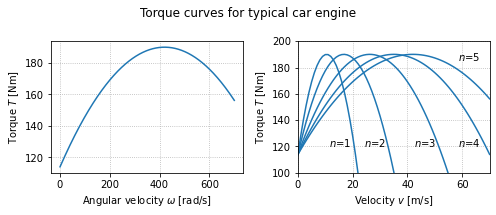

In [4]:
# Figure 4.2
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

# (a) - single torque curve as function of omega
ax = axes[0]
omega = np.linspace(0, 700, 701)
ax.plot(omega, motor_torque(omega))
ax.set_xlabel(r'Angular velocity $\omega$ [rad/s]')
ax.set_ylabel('Torque $T$ [Nm]')
ax.grid(True, linestyle='dotted')

# (b) - torque curves in different gears, as function of velocity
ax = axes[1]
v = np.linspace(0, 70, 71)
alpha = [40, 25, 16, 12, 10]
for gear in range(5):
    omega = alpha[gear] * v
    T = motor_torque(omega)
    plt.plot(v, T, color='#1f77b4', linestyle='solid')

# Set up the axes and style
ax.axis([0, 70, 100, 200])
ax.grid(True, linestyle='dotted')

# Add labels
plt.text(11.5, 120, '$n$=1')
ax.text(24, 120, '$n$=2')
ax.text(42.5, 120, '$n$=3')
ax.text(58.5, 120, '$n$=4')
ax.text(58.5, 185, '$n$=5')
ax.set_xlabel('Velocity $v$ [m/s]')
ax.set_ylabel('Torque $T$ [Nm]')

plt.suptitle('Torque curves for typical car engine')
plt.tight_layout()

### Input/ouput model for the vehicle system

We now create an input/output model for the vehicle system that takes the throttle input $u$, the gear and the angle of the road $\theta$ as input.  The output of this model is the current vehicle velocity $v$.

In [5]:
vehicle = ct.NonlinearIOSystem(
    vehicle_update, None, name='vehicle',
    inputs = ('u', 'gear', 'theta'), outputs = ('v'), states=('v'))

# Define a function for creating a "standard" cruise control plot
def cruise_plot(sys, t, y, label=None, t_hill=None, vref=20, antiwindup=False,
                linetype='b-', subplots=None, legend=None):
    if subplots is None:
        subplots = [None, None]
    # Figure out the plot bounds and indices
    v_min = vref - 1.2; v_max = vref + 0.5; v_ind = sys.find_output('v')
    u_min = 0; u_max = 2 if antiwindup else 1; u_ind = sys.find_output('u')

    # Make sure the upper and lower bounds on v are OK
    while max(y[v_ind]) > v_max: v_max += 1
    while min(y[v_ind]) < v_min: v_min -= 1

    # Create arrays for return values
    subplot_axes = list(subplots)

    # Velocity profile
    if subplot_axes[0] is None:
        subplot_axes[0] = plt.subplot(2, 1, 1)
    else:
        plt.sca(subplots[0])
    plt.plot(t, y[v_ind], linetype)
    plt.plot(t, vref*np.ones(t.shape), 'k-')
    if t_hill:
        plt.axvline(t_hill, color='k', linestyle='--', label='t hill')
    plt.axis([0, t[-1], v_min, v_max])
    plt.xlabel('Time $t$ [s]')
    plt.ylabel('Velocity $v$ [m/s]')

    # Commanded input profile
    if subplot_axes[1] is None:
        subplot_axes[1] = plt.subplot(2, 1, 2)
    else:
        plt.sca(subplots[1])
    plt.plot(t, y[u_ind], 'r--' if antiwindup else linetype, label=label)
    # Applied input profile
    if antiwindup:
        plt.plot(t, np.clip(y[u_ind], 0, 1), linetype, label='Applied')
    if t_hill:
        plt.axvline(t_hill, color='k', linestyle='--')
    if legend:
        plt.legend(frameon=False)
    plt.axis([0, t[-1], u_min, u_max])
    plt.xlabel('Time $t$ [s]')
    plt.ylabel('Throttle $u$')

    return subplot_axes

## State space controller

Construct a state space controller with integral action, linearized around an equilibrium point.  The controller is constructed around the equilibrium point $(x_d, u_d)$ and includes both feedforward and feedback compensation.

* Controller inputs - $(x, y, r)$: system states, system output, reference
* Controller state - $z$: integrated error $(y - r)$
* Controller output - $u$: state feedback control

Note: to make the structure of the controller more clear, we implement this as a "nonlinear" input/output module, even though the actual input/output system is linear.  This also allows the use of parameters to set the operating point and gains for the controller.


In [6]:
def sf_update(t, z, u, params={}):
    y, r = u[1], u[2]
    return y - r

def sf_output(t, z, u, params={}):
    # Get the controller parameters that we need
    K = params.get('K', 0)
    ki = params.get('ki', 0)
    kf = params.get('kf', 0)
    xd = params.get('xd', 0)
    yd = params.get('yd', 0)
    ud = params.get('ud', 0)

    # Get the system state and reference input
    x, y, r = u[0], u[1], u[2]

    return ud - K * (x - xd) - ki * z + kf * (r - yd)

# Create the input/output system for the controller
control_sf = ct.NonlinearIOSystem(
    sf_update, sf_output, name='control',
    inputs=('x', 'y', 'r'),
    outputs=('u'),
    states=('z'))

# Create the closed loop system for the state space controller
cruise_sf = ct.InterconnectedSystem(
    (vehicle, control_sf), name='cruise',
    connections=(
        ('vehicle.u', 'control.u'),
        ('control.x', 'vehicle.v'),
        ('control.y', 'vehicle.v')),
    inplist=('control.r', 'vehicle.gear', 'vehicle.theta'),
    outlist=('control.u', 'vehicle.v'), outputs=['u', 'v'])

# Define the time and input vectors
T = np.linspace(0, 25, 501)
vref = 20 * np.ones(T.shape)
gear = 4 * np.ones(T.shape)
theta0 = np.zeros(T.shape)

# Find the equilibrium point for the system
Xeq, Ueq = ct.find_eqpt(
    vehicle, [vref[0]], [0, gear[0], theta0[0]], y0=[vref[0]], iu=[1, 2])
print("Xeq = ", Xeq)
print("Ueq = ", Ueq)

# Compute the linearized system at the eq pt
cruise_linearized = ct.linearize(vehicle, Xeq, [Ueq[0], gear[0], 0])

Xeq =  [20.]
Ueq =  [0.16874874 4.         0.        ]


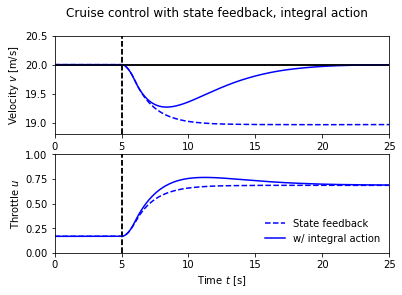

In [7]:
# Construct the gain matrices for the system
A, B, C = cruise_linearized.A, cruise_linearized.B[0, 0], cruise_linearized.C
K = 0.5
kf = -1 / (C * np.linalg.inv(A - B * K) * B)

# Compute the steady state velocity and throttle setting
xd = Xeq[0]
ud = Ueq[0]
yd = vref[-1]

# Response of the system with no integral feedback term
plt.figure()
theta_hill = [
    0 if t <= 5 else
    4./180. * pi * (t-5) if t <= 6 else
    4./180. * pi for t in T]
t, y_sfb = ct.input_output_response(
    cruise_sf, T, [vref, gear, theta_hill], [Xeq[0], 0],
    params={'K':K, 'ki':0.0, 'kf':kf, 'xd':xd, 'ud':ud, 'yd':yd})
subplots = cruise_plot(cruise_sf, t, y_sfb, t_hill=5, linetype='b--')

# Response of the system with state feedback + integral action
t, y_sfb_int = ct.input_output_response(
    cruise_sf, T, [vref, gear, theta_hill], [Xeq[0], 0],
    params={'K':K, 'ki':0.1, 'kf':kf, 'xd':xd, 'ud':ud, 'yd':yd})
cruise_plot(cruise_sf, t, y_sfb_int, t_hill=5, linetype='b-', subplots=subplots)

# Add title and legend
plt.suptitle('Cruise control with state feedback, integral action')
import matplotlib.lines as mlines
p_line = mlines.Line2D([], [], color='blue', linestyle='--', label='State feedback')
pi_line = mlines.Line2D([], [], color='blue', linestyle='-', label='w/ integral action')
plt.legend(handles=[p_line, pi_line], frameon=False, loc='lower right');

## Pole/zero cancellation

The transfer function for the linearized dynamics of the cruise control system is given by $P(s) = b/(s+a)$.  A simple (but not necessarily good) way to design a PI controller is to choose the parameters of the PI controller as $k_\text{i}=ak_\text{p}$.  The controller transfer function is then $C(s)=k_\text{p}+k_\text{i}/s=k_\text{i}(s+a)/s$. It has a zero at $s = -k_\text{i}/k_\text{p}=-a$ that cancels the process pole at $s = -a$. We have $P(s)C(s)=k_\text{i}/s$ giving the transfer function from reference to vehicle velocity as $G_{yr}(s)=b k_\text{p}/(s + b k_\text{p})$, and control design is then simply a matter of choosing the gain $k_\text{p}$. The closed loop system dynamics are of first order with the time constant $1/(b k_\text{p})$.

system: a =  0.010124405669387215 , b =  1.3203061238159202
pzcancel: kp = 0.5 , ki = 0.005062202834693608 , 1/(kp b) =  1.5148002148317266
sfb_int: K =  0.5 , ki = 0.1


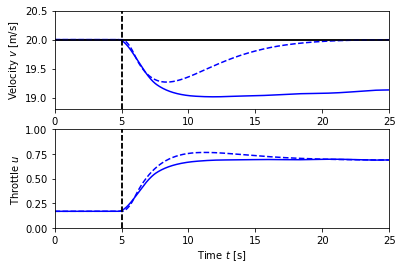

In [8]:
# Get the transfer function from throttle input + hill to vehicle speed
P = ct.ss2tf(cruise_linearized[0, 0])

# Construction a controller that cancels the pole
kp = 0.5
a = -P.pole()[0]
b = np.real(P(0)) * a
ki = a * kp
C = ct.tf2ss(ct.TransferFunction([kp, ki], [1, 0]))
control_pz = ct.LinearIOSystem(C, name='control', inputs='u', outputs='y')
print("system: a = ", a, ", b = ", b)
print("pzcancel: kp =", kp, ", ki =", ki, ", 1/(kp b) = ", 1/(kp * b))
print("sfb_int: K = ", K, ", ki = 0.1")

# Construct the closed loop system and plot the response
# Create the closed loop system for the state space controller
cruise_pz = ct.InterconnectedSystem(
    (vehicle, control_pz), name='cruise_pz',
    connections = (
        ('control.u', '-vehicle.v'),
        ('vehicle.u', 'control.y')),
    inplist = ('control.u', 'vehicle.gear', 'vehicle.theta'),
    inputs = ('vref', 'gear', 'theta'),
    outlist = ('vehicle.v', 'vehicle.u'),
    outputs = ('v', 'u'))

# Find the equilibrium point
X0, U0 = ct.find_eqpt(
    cruise_pz, [vref[0], 0], [vref[0], gear[0], theta0[0]], 
    iu=[1, 2], y0=[vref[0], 0], iy=[0])

# Response of the system with PI controller canceling process pole
t, y_pzcancel = ct.input_output_response(
    cruise_pz, T, [vref, gear, theta_hill], X0)
subplots = cruise_plot(cruise_pz, t, y_pzcancel, t_hill=5, linetype='b-')
cruise_plot(cruise_sf, t, y_sfb_int, t_hill=5, linetype='b--', subplots=subplots);

## PI Controller

In this example, the speed of the vehicle is measured and compared to the desired speed.  The controller is a PI controller represented as a transfer function.  In the textbook, the simulations are done for LTI systems, but here we simulate the full nonlinear system.

### Parameter design through pole placement

To illustrate the design of a PI controller, we choose the gains $k_\text{p}$ and $k_\text{i}$ so that the characteristic polynomial has the form

$$
s^2 + 2 \zeta \omega_0 s + \omega_0^2
$$

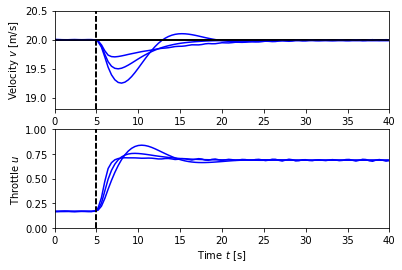

In [9]:
# Values of the first order transfer function P(s) = b/(s + a) are set above

# Define the input that we want to track
T = np.linspace(0, 40, 101)
vref = 20 * np.ones(T.shape)
gear = 4 * np.ones(T.shape)
theta_hill = np.array([
    0 if t <= 5 else
    4./180. * pi * (t-5) if t <= 6 else
    4./180. * pi for t in T])

# Fix \omega_0 and vary \zeta
w0 = 0.5
subplots = [None, None]
for zeta in [0.5, 1, 2]:
    # Create the controller transfer function (as an I/O system)
    kp = (2*zeta*w0 - a)/b
    ki = w0**2 / b
    control_tf = ct.tf2io(
        ct.TransferFunction([kp, ki], [1, 0.01*ki/kp]),
        name='control', inputs='u', outputs='y')
    
    # Construct the closed loop system by interconnecting process and controller
    cruise_tf = ct.InterconnectedSystem(
    (vehicle, control_tf), name='cruise',
    connections = [('control.u', '-vehicle.v'), ('vehicle.u', 'control.y')],
    inplist = ('control.u', 'vehicle.gear', 'vehicle.theta'), 
        inputs = ('vref', 'gear', 'theta'),
    outlist = ('vehicle.v', 'vehicle.u'), outputs = ('v', 'u'))

    # Plot the velocity response
    X0, U0 = ct.find_eqpt(
        cruise_tf, [vref[0], 0], [vref[0], gear[0], theta_hill[0]], 
        iu=[1, 2], y0=[vref[0], 0], iy=[0])

    t, y = ct.input_output_response(cruise_tf, T, [vref, gear, theta_hill], X0)
    subplots = cruise_plot(cruise_tf, t, y, t_hill=5, subplots=subplots)

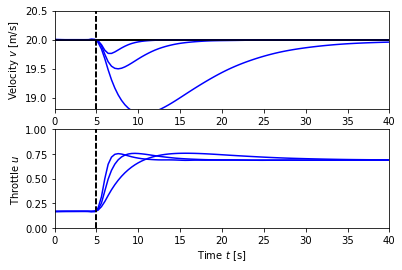

In [10]:
# Fix \zeta and vary \omega_0
zeta = 1
subplots = [None, None]
for w0 in [0.2, 0.5, 1]:
    # Create the controller transfer function (as an I/O system)
    kp = (2*zeta*w0 - a)/b
    ki = w0**2 / b
    control_tf = ct.tf2io(
        ct.TransferFunction([kp, ki], [1, 0.01*ki/kp]),
        name='control', inputs='u', outputs='y')
    
    # Construct the closed loop system by interconnecting process and controller
    cruise_tf = ct.InterconnectedSystem(
    (vehicle, control_tf), name='cruise',
    connections = [('control.u', '-vehicle.v'), ('vehicle.u', 'control.y')],
    inplist = ('control.u', 'vehicle.gear', 'vehicle.theta'), 
        inputs = ('vref', 'gear', 'theta'),
    outlist = ('vehicle.v', 'vehicle.u'), outputs = ('v', 'u'))

    # Plot the velocity response
    X0, U0 = ct.find_eqpt(
        cruise_tf, [vref[0], 0], [vref[0], gear[0], theta_hill[0]], 
        iu=[1, 2], y0=[vref[0], 0], iy=[0])

    t, y = ct.input_output_response(cruise_tf, T, [vref, gear, theta_hill], X0)
    subplots = cruise_plot(cruise_tf, t, y, t_hill=5, subplots=subplots)

### Robustness to change in mass

In [11]:
# Nominal controller design for remaining analyses
# Construct a PI controller with rolloff, as a transfer function
Kp = 0.5                        # proportional gain
Ki = 0.1                        # integral gain
control_tf = ct.tf2io(
    ct.TransferFunction([Kp, Ki], [1, 0.01*Ki/Kp]),
    name='control', inputs='u', outputs='y')

cruise_tf = ct.InterconnectedSystem(
    (vehicle, control_tf), name='cruise',
    connections = [('control.u', '-vehicle.v'), ('vehicle.u', 'control.y')],
    inplist = ('control.u', 'vehicle.gear', 'vehicle.theta'), inputs = ('vref', 'gear', 'theta'),
    outlist = ('vehicle.v', 'vehicle.u'), outputs = ('v', 'u'))

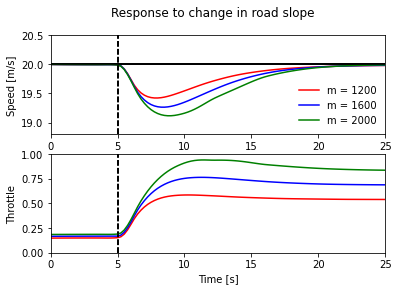

In [12]:
# Define the time and input vectors
T = np.linspace(0, 25, 101)
vref = 20 * np.ones(T.shape)
gear = 4 * np.ones(T.shape)
theta0 = np.zeros(T.shape)

# Now simulate the effect of a hill at t = 5 seconds
plt.figure()
plt.suptitle('Response to change in road slope')
theta_hill = np.array([
    0 if t <= 5 else
    4./180. * pi * (t-5) if t <= 6 else
    4./180. * pi for t in T])

subplots = [None, None]
linecolor = ['red', 'blue', 'green']
handles = []
for i, m in enumerate([1200, 1600, 2000]):
    # Compute the equilibrium state for the system
    X0, U0 = ct.find_eqpt(
        cruise_tf, [vref[0], 0], [vref[0], gear[0], theta0[0]], 
        iu=[1, 2], y0=[vref[0], 0], iy=[0], params={'m':m})

    t, y = ct.input_output_response(
        cruise_tf, T, [vref, gear, theta_hill], X0, params={'m':m})

    subplots = cruise_plot(cruise_tf, t, y, t_hill=5, subplots=subplots,
                           linetype=linecolor[i][0] + '-')
    handles.append(mlines.Line2D([], [], color=linecolor[i], linestyle='-', 
                                 label="m = %d" % m))

# Add labels to the plots
plt.sca(subplots[0])
plt.ylabel('Speed [m/s]')
plt.legend(handles=handles, frameon=False, loc='lower right');

plt.sca(subplots[1])
plt.ylabel('Throttle')
plt.xlabel('Time [s]');

## PI controller with  antiwindup protection

We now create a more complicated feedback controller that includes anti-windup protection.

In [13]:
def pi_update(t, x, u, params={}):
    # Get the controller parameters that we need
    ki = params.get('ki', 0.1)
    kaw = params.get('kaw', 2)  # anti-windup gain

    # Assign variables for inputs and states (for readability)
    v = u[0]                    # current velocity
    vref = u[1]                 # reference velocity
    z = x[0]                    # integrated error

    # Compute the nominal controller output (needed for anti-windup)
    u_a = pi_output(t, x, u, params)

    # Compute anti-windup compensation (scale by ki to account for structure)
    u_aw = kaw/ki * (np.clip(u_a, 0, 1) - u_a) if ki != 0 else 0

    # State is the integrated error, minus anti-windup compensation
    return (vref - v) + u_aw

def pi_output(t, x, u, params={}):
    # Get the controller parameters that we need
    kp = params.get('kp', 0.5)
    ki = params.get('ki', 0.1)

    # Assign variables for inputs and states (for readability)
    v = u[0]                    # current velocity
    vref = u[1]                 # reference velocity
    z = x[0]                    # integrated error

    # PI controller
    return kp * (vref - v) + ki * z

control_pi = ct.NonlinearIOSystem(
    pi_update, pi_output, name='control',
    inputs = ['v', 'vref'], outputs = ['u'], states = ['z'],
    params = {'kp':0.5, 'ki':0.1})

# Create the closed loop system
cruise_pi = ct.InterconnectedSystem(
    (vehicle, control_pi), name='cruise',
    connections=(
        ('vehicle.u', 'control.u'),
        ('control.v', 'vehicle.v')),
    inplist=('control.vref', 'vehicle.gear', 'vehicle.theta'),
    outlist=('control.u', 'vehicle.v'), outputs=['u', 'v'])

### Response to a small hill

Figure 4.3b shows the response of the closed loop system.  The figure shows that even if the hill is so steep that the throttle changes from 0.17 to almost full throttle, the largest speed error is less than 1 m/s, and the desired velocity is recovered after 20 s.

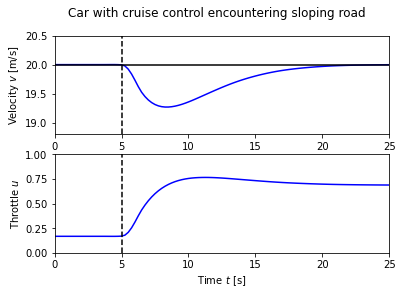

In [14]:
# Compute the equilibrium throttle setting for the desired speed
X0, U0, Y0 = ct.find_eqpt(
    cruise_pi, [vref[0], 0], [vref[0], gear[0], theta0[0]],
    y0=[0, vref[0]], iu=[1, 2], iy=[1], return_y=True)

# Now simulate the effect of a hill at t = 5 seconds
plt.figure()
plt.suptitle('Car with cruise control encountering sloping road')
theta_hill = [
    0 if t <= 5 else
    4./180. * pi * (t-5) if t <= 6 else
    4./180. * pi for t in T]
t, y = ct.input_output_response(
    cruise_pi, T, [vref, gear, theta_hill], X0)
cruise_plot(cruise_pi, t, y, t_hill=5);

### Effect of Windup

The windup effect occurs when a car encounters a hill that is so steep ($6^\circ$) that the throttle saturates when the cruise controller attempts to maintain speed.

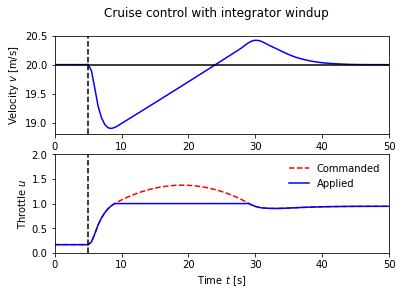

In [15]:
plt.figure()
plt.suptitle('Cruise control with integrator windup')
T = np.linspace(0, 50, 101)
vref = 20 * np.ones(T.shape)
theta_hill = [
    0 if t <= 5 else
    6./180. * pi * (t-5) if t <= 6 else
    6./180. * pi for t in T]
t, y = ct.input_output_response(
    cruise_pi, T, [vref, gear, theta_hill], X0,
    params={'kaw':0})
cruise_plot(cruise_pi, t, y, label='Commanded', t_hill=5, 
            antiwindup=True, legend=True);

### PI controller with anti-windup compensation

Anti-windup can be applied to the system to improve the response. Because of the feedback from the actuator model, the output of the integrator is quickly reset to a value such that the controller output is at the saturation limit.

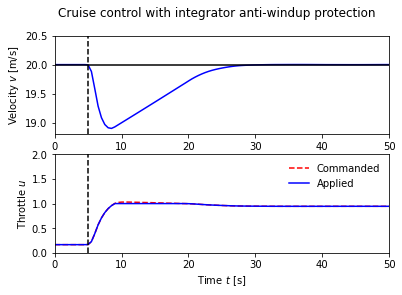

In [16]:
plt.figure()
plt.suptitle('Cruise control with integrator anti-windup protection')
t, y = ct.input_output_response(
    cruise_pi, T, [vref, gear, theta_hill], X0,
    params={'kaw':2.})
cruise_plot(cruise_pi, t, y, label='Commanded', t_hill=5, 
            antiwindup=True, legend=True);